## Classification
Notebook to evaluate efficacy of classification between different thalamic cell type groups

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import pickle
import json

### To do:
1) Benchmark simple Wilcoxon selection, for various sizes of gene panels
2) Benchmark w/ and w/o absolute values

In [2]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
devData = sc.read("../Data/devData.h5ad")
# Index by cell class
gluData = devData[devData.obs.class_label == "Glutamatergic"]

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
# Acquire genes
def getUniqueGenes(geneDict, perClass = 1):
    """ Function to find X number of genes per class for a given gene dictionary, and assemble them
    into a list of unique genes. """
    import numpy as np
    
    keyNames = list(geneDict.keys())
    if perClass > len(geneDict[keyNames[0]]):
        print("Requested genes per class greater than number contained within first dict element - using that instead.")
        perClass = len(geneDict[keyNames[0]])
    
    geneList = []
    for name in keyNames:
        geneList.append(geneDict[name][0:perClass])
        
    geneList = np.unique(geneList)
    return geneList

In [4]:
def evalPanel(geneData,genePanel,cluster, showPlot = True):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Plot confusion matrix if requested
    if showPlot:
        plt.figure(figsize=(48, 32), dpi=80)
        confMatrix = confusion_matrix(cluster.to_numpy(),assignedCluster)
        ax = sns.heatmap(confMatrix) # cmap = "viridis")
        
        # Format heatmap
        nClusters = len(pd.unique(cluster))
        plt.xticks(np.linspace(0.5,nClusters - .5,nClusters), pd.unique(cluster), fontsize = 8)
        plt.yticks(np.linspace(0.5,nClusters - .5,nClusters), pd.unique(cluster), fontsize = 8)
        plt.title("Classification Accuracy: %1.1f%%" %round(accuracy*100,2),fontsize=36)
        plt.xlabel("Original Label", fontsize = 24)
        plt.ylabel("Assigned Label", fontsize = 24)
        return accuracy, ax, confMatrix
    else:
        return accuracy

In [5]:
# Load DE data
with open("../Data/wilcoxon_rank_genes.pickle", "rb") as f:
    clusterWilcoxon = pickle.load(f)
    
gluData.uns["rank_genes_groups"] = clusterWilcoxon
# Create a super list dictionary of top marker genes for each subclass, which can be later indexed for specific gene panels
markerGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:500,:]
    genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
    markerGenes[indx] = genesFiltered["names"][0:32].tolist()

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [6]:
# Assemble a dictionary w/ varying length gene panels
wlPanel = {}
panelIDs = [1, 2, 3, 4, 8, 16, 32]
for i in panelIDs:
    geneList = list(getUniqueGenes(markerGenes,i))
    wlPanel[str(len(geneList))] = geneList

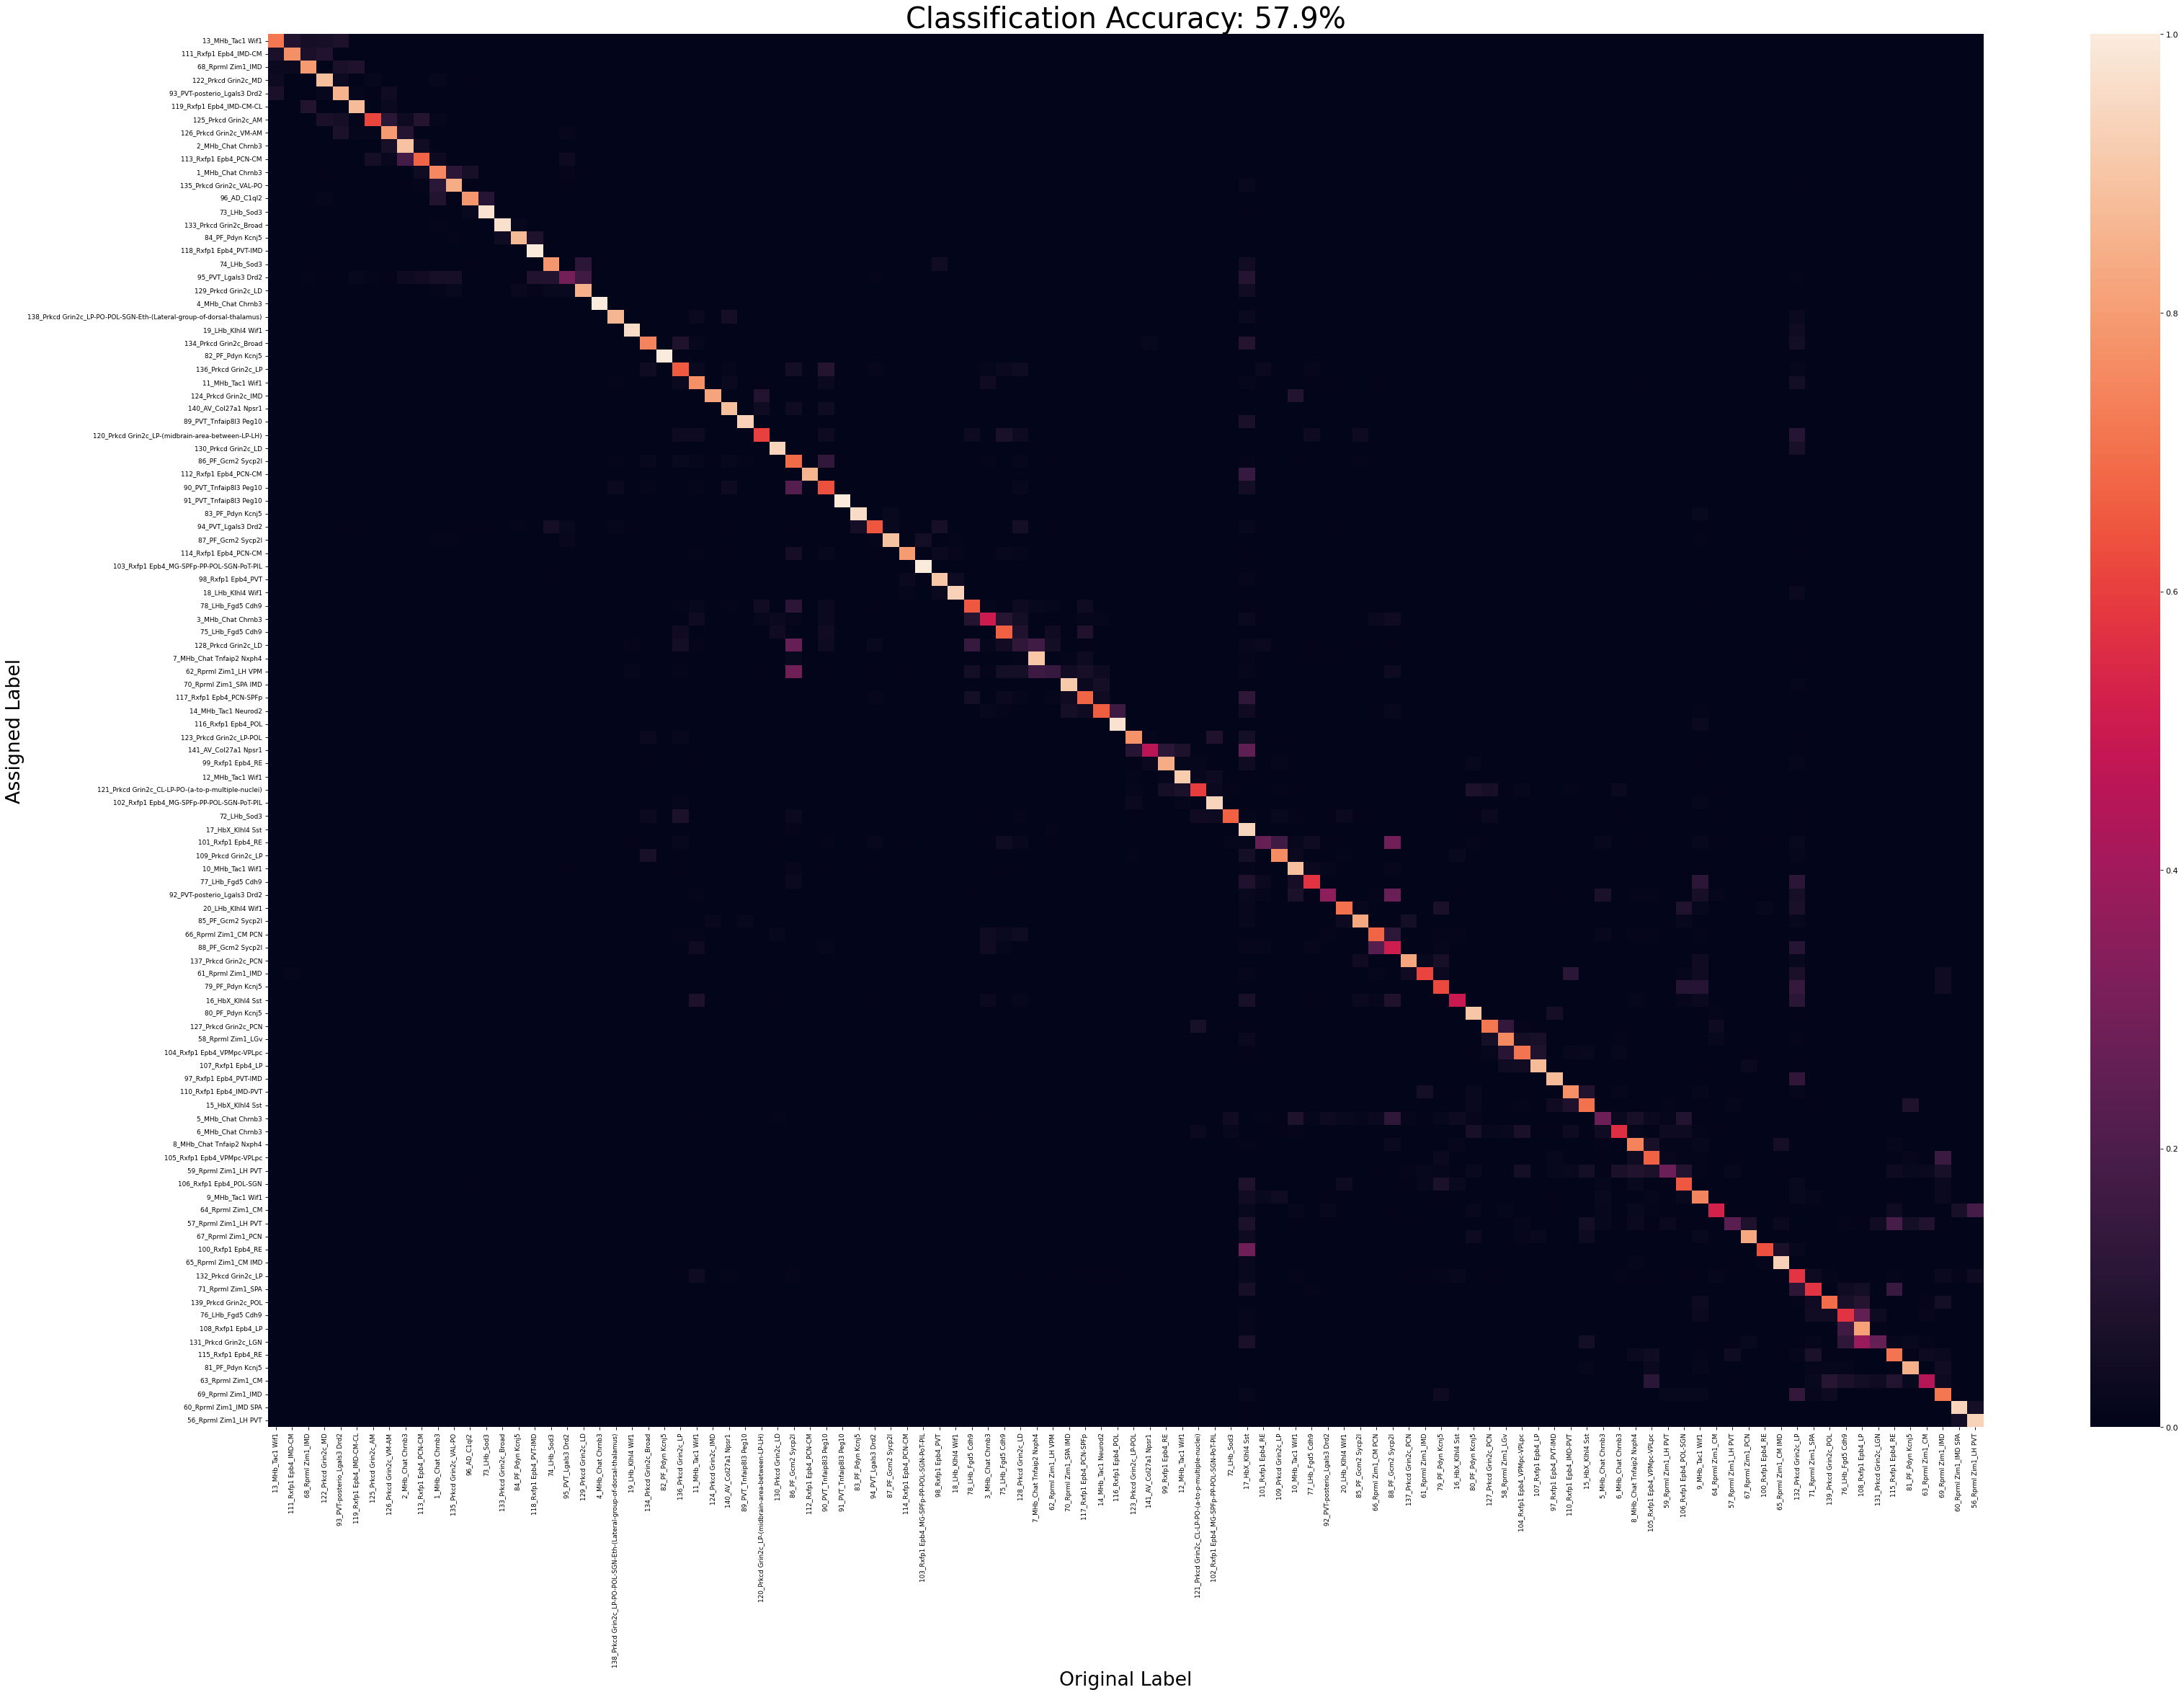

In [11]:
# Check how a particular gene panel does w/ confusion matrix
# plt.figure(figsize=(12, 8), dpi=160)
evalPanel(gluData,wlPanel['363'],gluData.obs["cluster_label"],True);

Text(0.5, 1.0, 'Gene Panel Efficacy: Wilcoxon Method')

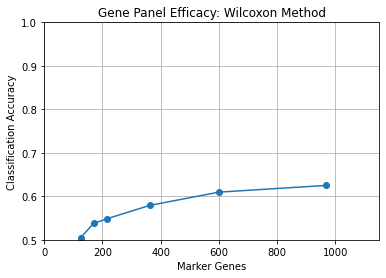

In [7]:
# Systematically evaluate gene panels
wlAccuracy = [evalPanel(gluData,wlPanel[i],gluData.obs["cluster_label"],False) for i in wlPanel.keys()]
# Plot results
fig, ax = plt.subplots()
plt.plot(np.fromiter(wlPanel.keys(),'int'),wlAccuracy,'o-')
ax.set_ylim(0.5, 1)
ax.set_xlim(0, 1150)
plt.grid()
plt.xlabel("Marker Genes")
plt.ylabel("Classification Accuracy")
plt.title("Gene Panel Efficacy: Wilcoxon Method")

## Compare gene selectors
Use gene panels provided by Wilcoxon rank testing, scGeneFit, PROPOSE (in progress)

In [ ]:
with open("../Results/Gene Panels/scGeneFit_p11_p14_panel.json", "r") as f:
    gfPanel = json.load(f)
    
with open("../Results/Gene Panels/PROPOSE_p11_p14_panel.json", "r") as f:
    prPanel = json.load(f)
    
with open("../Results/Gene Panels/activeSVM_p11_p14_panel.json", "r") as f:
    svPanel = json.load(f)
    
with open("../Results/Gene Panels/Marcus_p11_p14_panel.json", "r") as f:
    mrPanel = json.load(f)
# Marcus' panel has 3 extra genes not in my dataset
m2Panel = set(mrPanel['483']) - (set(mrPanel['483']) - set(gluData.var_names))
mrPanel = {len(m2Panel) : list(m2Panel)}

In [ ]:
# Systematically evaluate gene panels
wlAccuracy = [evalPanel(gluData,wlPanel[i],gluData.obs["cluster_label"],False) for i in wlPanel.keys()]
gfAccuracy = [evalPanel(gluData,gfPanel[i],gluData.obs["cluster_label"],False) for i in gfPanel.keys()]
prAccuracy = [evalPanel(gluData,prPanel[i],gluData.obs["cluster_label"],False) for i in prPanel.keys()]
svAccuracy = [evalPanel(gluData,svPanel[i],gluData.obs["cluster_label"],False) for i in svPanel.keys()]
mrAccuracy = [evalPanel(gluData,mrPanel[i],gluData.obs["cluster_label"],False) for i in mrPanel.keys()]

In [ ]:
# Plot benchmarking
plt.figure(figsize=(5, 3), dpi=100)
nClusters = len(gluData.obs["cluster_label"].unique())
plt.plot(np.fromiter(wlPanel.keys(), dtype='int'),wlAccuracy,'o-',label="Wilcoxon")
plt.plot(np.fromiter(gfPanel.keys(), dtype='int'),gfAccuracy,'o-', label="scGeneFit")
plt.plot(np.fromiter(prPanel.keys(), dtype='int'),prAccuracy,'o-', label="PROPOSE")
plt.plot(np.fromiter(svPanel.keys(), dtype='int'),svAccuracy,'o-', label="activeSVM")
plt.plot(np.fromiter(mrPanel.keys(), dtype='int'),mrAccuracy,'o-', label="maxDiverse")

# Clean up plot
plt.ylim(.5,.8)
plt.xlim(0,1000)
plt.grid()
plt.xlabel("Marker Genes")
plt.ylabel("Classification Accuracy")
plt.title("Development Panel Accuracy")
plt.legend()